In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt


from imp import reload
import sys
sys.path.insert(0, '..')
import utilities as ut

from skimage import img_as_float
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import grid_points_in_poly

# Data Import

In [2]:
hst = img_as_float(ut.read_hyperstack('../data/wt_gbe_20180110.h5'))

In [3]:
mhst = ut.read_hyperstack('../data/wt_gbe_20180110_mask.h5')[:,300:800,:]

# Setup roi binning

In [4]:
xgrid = np.linspace(0,1024,20).astype(int)
xgrid

array([   0,   53,  107,  161,  215,  269,  323,  377,  431,  485,  538,
        592,  646,  700,  754,  808,  862,  916,  970, 1024])

In [5]:
ygrid = np.array([0,180,500])
ygrid

array([  0, 180, 500])

Create a set of rois that split image into a grid across the embryo

In [6]:
# Split image into a grid
rois = np.zeros_like(mhst[0])

n=1
for j in range(len(ygrid)-1):
    y = ygrid[j]
    ydt = ygrid[j+1]
    for i in range(len(xgrid)-1):
        x = xgrid[i]
        xdt = xgrid[i+1]
        
        if j > 0:
            xdt = xgrid[-i-1]
            x = xgrid[-i-2]
            
#         print(n,x,xdt,y,ydt)
#         print(n)
        rois[y:ydt,x:xdt] = n
        n = n+1

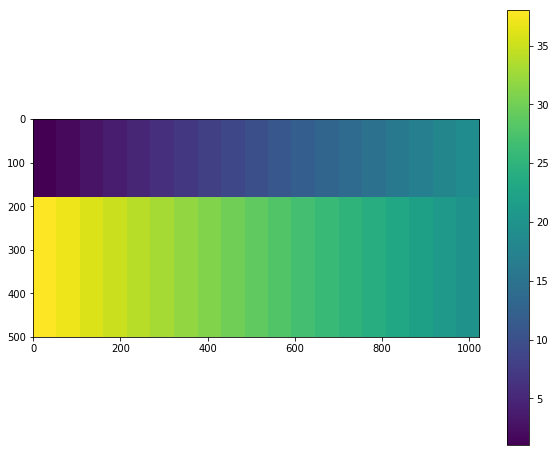

In [7]:
ut.imshow(rois)

In [9]:
nroi = np.unique(rois).shape
nroi

(38,)

Calculate the average intensity in each roi for a single masked image. Must use `np.nanmean` since the masked background is now set to be `np.nan`

In [10]:
Lavgs = []
for t in range(mhst.shape[0]):
    avgs = []
    for n in range(1,nroi[0]+1):
        avgs.append(np.nanmean(mhst[i][rois==n]))
    Lavgs.append(pd.DataFrame({'avg_intensity':avgs,'roi':range(1,nroi[0]+1)}))

Create a tidy dataframe

In [11]:
avg_int = pd.concat(Lavgs,keys=range(mhst.shape[0]))

In [12]:
avg_int = avg_int.reset_index().rename(columns={'level_0':'frame'}).drop('level_1',axis=1)

In [28]:
avg_int.head()

,frame,avg_intensity,roi
0,0,0.055738,1
1,0,0.172289,2
2,0,0.229762,3
3,0,0.235387,4
4,0,0.194955,5


# Derivative of `avg_intensity`

In [30]:
grouproi = avg_int.groupby('roi')

Comparing between adjacent rois is not effective because it just highlights that some rois have more yolk background signal than others. Instead it would be better to look at how the value of a single roi changes overtime.

We can use the `pd.diff` method to calculate the difference in a particular column by comparing the value of adjacent rows.

In [32]:
grouproi['d_intensity'] = grouproi['avg_intensity'].diff()

TypeError: 'DataFrameGroupBy' object does not support item assignment

In [33]:
grouproi.diff()

,avg_intensity,frame
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


`pd.diff` doesn't appear to work as desired on a `pd.groupby` object. For the time being, it may be more expedient to use a brute force/loop method to get an idea of what the derivative data might look like.

https://stackoverflow.com/questions/20670726/computing-diffs-in-pandas-after-using-groupby-leads-to-unexpected-result

**NB:** At some point it may be helpful to have a columns that give the column/row position of the roi as opposed to the index number.

# Brute force derivative of `avg_intensity`

Starting with the dataframe `avg_int`. For each roi, calculate the `diff` (derivative) for the `avg_intensity` column.

In [14]:
diffs = []
for i in avg_int['roi'].unique():
    print(i)
    diffs.append(avg_int[avg_int['roi']==i]['avg_intensity'].diff())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [15]:
diffs

[0       NaN
 38      0.0
 76      0.0
 114     0.0
 152     0.0
 190     0.0
 228     0.0
 266     0.0
 304     0.0
 342     0.0
 380     0.0
 418     0.0
 456     0.0
 494     0.0
 532     0.0
 570     0.0
 608     0.0
 646     0.0
 684     0.0
 722     0.0
 760     0.0
 798     0.0
 836     0.0
 874     0.0
 912     0.0
 950     0.0
 988     0.0
 1026    0.0
 1064    0.0
 1102    0.0
        ... 
 5206    0.0
 5244    0.0
 5282    0.0
 5320    0.0
 5358    0.0
 5396    0.0
 5434    0.0
 5472    0.0
 5510    0.0
 5548    0.0
 5586    0.0
 5624    0.0
 5662    0.0
 5700    0.0
 5738    0.0
 5776    0.0
 5814    0.0
 5852    0.0
 5890    0.0
 5928    0.0
 5966    0.0
 6004    0.0
 6042    0.0
 6080    0.0
 6118    0.0
 6156    0.0
 6194    0.0
 6232    0.0
 6270    0.0
 6308    0.0
 Name: avg_intensity, Length: 167, dtype: float64, 1       NaN
 39      0.0
 77      0.0
 115     0.0
 153     0.0
 191     0.0
 229     0.0
 267     0.0
 305     0.0
 343     0.0
 381     0.0
 419     0.0
 

This gives us lots of zeros and some `np.nan`, which indicates that something isn't working appropriately. Let's focus on a single roi and see if the `diff` operation makes sense

In [17]:
roi = avg_int[avg_int['roi']==1]

In [19]:
roi.head()

,frame,avg_intensity,roi
0,0,0.055738,1
38,1,0.055738,1
76,2,0.055738,1
114,3,0.055738,1
152,4,0.055738,1


Data appear to be sorted according to `frame`

In [20]:
roi.diff()

,frame,avg_intensity,roi
0,NaN,NaN,NaN
38,1.0,0.0,0.0
76,1.0,0.0,0.0
114,1.0,0.0,0.0
152,1.0,0.0,0.0
190,1.0,0.0,0.0
228,1.0,0.0,0.0
266,1.0,0.0,0.0
304,1.0,0.0,0.0
342,1.0,0.0,0.0


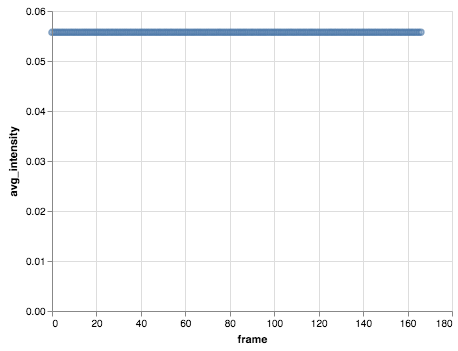

In [22]:
alt.Chart(roi
         ).mark_point(
        ).encode(
            x='frame:Q',
            y='avg_intensity:Q'
        )

It looks like our `average_intensity` value is the same for every frame/timepoint, which suggests that something may have gone wrong with the calculate of intensity from the masked images.